<>:370: SyntaxWarning: invalid escape sequence '\h'
<>:370: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-977792023.py:370: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('Predicted Slip Force $\hat{f}_{slip}$')


--- C1. Data Collection Phase ---


Generating Data: 100%|██████████| 25/25 [00:07<00:00,  3.20it/s]



--- C2. Model Learning Phase ---


Training KAN:  43%|████▎     | 65/150 [00:20<00:26,  3.17it/s, val_loss=4.3087e-01]



Early stopping at epoch 66
Training complete. Best validation loss: 3.7737e-01

--- Identification Accuracy (Test Set) ---
Model | Params | MSE (Norm.) | R²    
--------------------------------------
KAN   | 588    | 0.3752      | 0.6275
MLP   | 121    | 0.3124      | 0.6899

--- C5. Closed-Loop Evaluation ---
Simulating with KAN compensation...


Simulating KAN: 100%|██████████| 2000/2000 [00:01<00:00, 1392.38it/s]


Simulating with MLP compensation...


Simulating MLP: 100%|██████████| 2000/2000 [00:01<00:00, 1756.06it/s]


Simulating with None compensation...


Simulating None: 100%|██████████| 2000/2000 [00:00<00:00, 6312.90it/s]



--- Closed-Loop Path Tracking Performance ---
Controller               | RMS Lateral Error (m)
--------------------------------------------------
KAN Compensation         | 0.1499
MLP Compensation         | 0.1519
None Compensation        | 0.1500


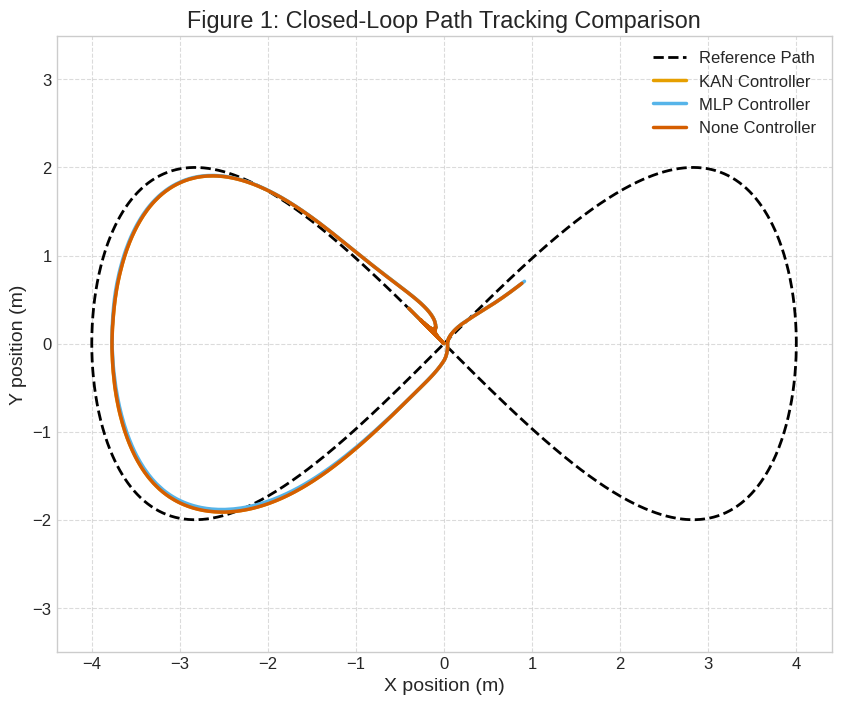

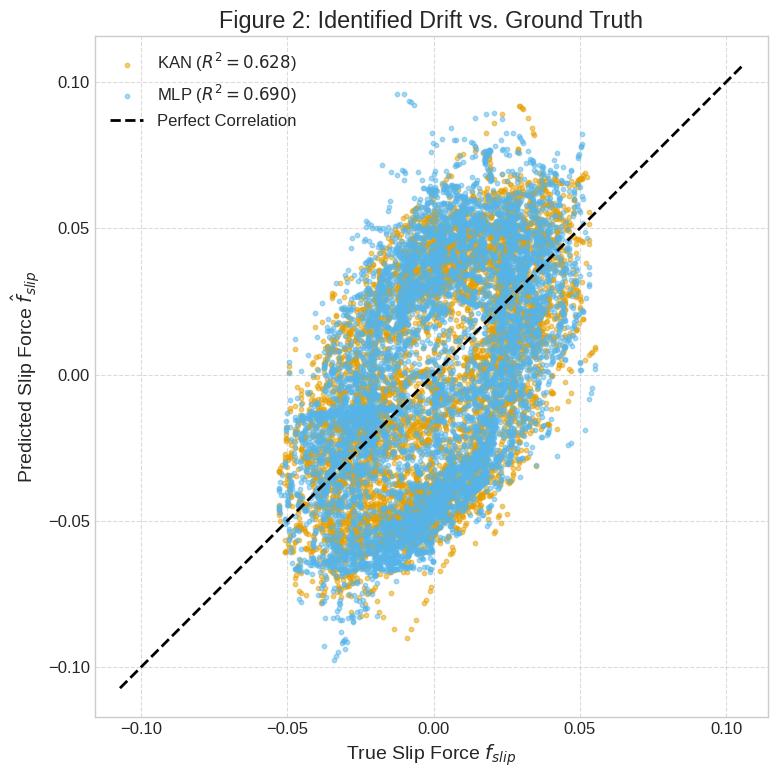

In [1]:
# ===================================================================
#   Mobile Robot Path Tracking with KANs
#
#   This script implements the experimental blueprint for identifying
#   and controlling a mobile robot with unknown nonlinear wheel slip
#   using Kolmogorov-Arnold Networks (KANs).
# ===================================================================

# --- 1. SETUP AND IMPORTS ----------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm # Use standard tqdm for console compatibility
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 14,
    'figure.figsize': (10, 7),
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.7,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})

# --- 2. SYSTEM AND SIMULATION FUNCTIONS --------------------------

def gl_weights(q, L):
    """Computes the weights for the Grünwald-Letnikov fractional derivative."""
    w = np.zeros(L + 1)
    w[0] = 1
    for k in range(1, L + 1):
        w[k] = w[k - 1] * (k - 1 - q) / k
    return w

def f_slip_ground_truth(q,state, omega_cmd, kappa, beta):
    """The 'unknown' nonlinear wheel-slip function to be learned."""
    _x, _y, _theta, v = state
    return kappa * v * np.tanh(beta * np.abs(omega_cmd))

def robot_step(q,x_current, u_cmd, x_hist, w_gl, h, slip_params):
    """
    Performs one integration step of the fractional-order robot dynamics.
    State: [x, y, theta, v], Input: [omega_cmd, a_cmd]
    """
    kappa, beta = slip_params
    _x, _y, theta, v = x_current
    omega_cmd, a_cmd = u_cmd

    # Compute fractional derivatives from history buffer using GL definition
    # This approximates D^q X at the current time step
    Dq_X = (1/h**q) * np.dot(w_gl, x_hist)

    # Calculate the rates of change based on the model equations ( D^q X = f(X, U) )
    rates = np.array([
        v * np.cos(theta),
        v * np.sin(theta),
        omega_cmd,
        -v + f_slip_ground_truth(q,x_current, omega_cmd, kappa, beta) + a_cmd
    ])

    # Update state using the forward Euler rule for fractional derivatives:
    # X_new = X_current + h^q * ( f(X,U) - D^q X_approx )
    # This solves for the next state that satisfies the fractional differential equation.
    x_new = x_current + h**q * (rates - Dq_X)

    return x_new

# --- 3. OPTIMIZED KAN CLASS (ROBUST B-SPLINE VERSION) -------------
# This class is generic and does not need modification.
class KAN:
    def __init__(self, width, knots, lr=3e-3, epochs=400, bs=512, weight_clip=3, weight_decay=1e-4):
        self.width = width
        self.knots = np.asarray(knots)
        self.nb = len(knots)
        self.lr = lr
        self.epochs = epochs
        self.bs = bs
        self.weight_clip = weight_clip
        self.weight_decay = weight_decay
        self.beta1 = 0.9; self.beta2 = 0.999; self.eps = 1e-8
        self.max_patience = 20 # As per blueprint
        n_in, n_hidden, n_out = width[0], width[1], width[2]
        n_param_c = n_in * n_hidden * self.nb
        self.theta = 0.05 * np.random.randn(n_param_c + n_hidden * n_out)
        self.C = self.theta[:n_param_c].reshape(self.nb, n_in, n_hidden)
        self.w_out = self.theta[n_param_c:].reshape(n_hidden, n_out)

    def _bspline_basis(self, x):
        x = x[:, np.newaxis]; k = self.knots[np.newaxis, :]
        kl = np.roll(k, 1, axis=1); kl[0, 0] = k[0, 0] - (k[0, 1] - k[0, 0])
        kr = np.roll(k, -1, axis=1); kr[0, -1] = k[0, -1] + (k[0, -1] - k[0, -2])
        asc_limb = (x - kl) / (k - kl + 1e-8); desc_limb = (kr - x) / (kr - k + 1e-8)
        phi = np.where((x >= kl) & (x <= k), asc_limb, 0.0)
        phi += np.where((x > k) & (x <= kr), desc_limb, 0.0)
        return phi

    def forward(self, X):
        m, n_in = X.shape
        PHI_all = np.empty((m, n_in, self.nb))
        for i in range(n_in): PHI_all[:, i, :] = self._bspline_basis(X[:, i])
        H = np.einsum('mik,kij->mj', PHI_all, self.C)
        y_hat = H @ self.w_out
        return y_hat, H, PHI_all

    def backprop(self, err, H, PHI_all):
        m = H.shape[0]; dL_dw = (1 / m) * (H.T @ err)
        G = (1 / m) * (err @ self.w_out.T)
        dL_dC = np.einsum('mik,mj->kij', PHI_all, G)
        grad = np.concatenate([dL_dC.flatten(), dL_dw.flatten()])
        return grad

    def fit(self, X_tr, y_tr, X_va, y_va):
        m1 = np.zeros_like(self.theta); v1 = np.zeros_like(self.theta)
        best_loss = np.inf; patience_counter = 0
        iterator = tqdm(range(self.epochs), desc="Training KAN")
        for ep in iterator:
            perm = np.random.permutation(X_tr.shape[0])
            for b in range(0, X_tr.shape[0], self.bs):
                idx = perm[b : b + self.bs]
                X_batch, y_batch = X_tr[idx], y_tr[idx]
                y_hat, H, PHI_all = self.forward(X_batch)
                err = y_hat - y_batch
                grad = self.backprop(err, H, PHI_all)
                m1 = self.beta1 * m1 + (1 - self.beta1) * grad
                v1 = self.beta2 * v1 + (1 - self.beta2) * (grad**2)
                m1h = m1 / (1 - self.beta1**(ep + 1)); v1h = v1 / (1 - self.beta2**(ep + 1))
                update = self.lr * m1h / (np.sqrt(v1h) + self.eps)
                self.theta -= (update + self.lr * self.weight_decay * self.theta)
                self.theta = np.clip(self.theta, -self.weight_clip, self.weight_clip)

            n_param_c = self.C.size
            self.C = self.theta[:n_param_c].reshape(self.C.shape)
            self.w_out = self.theta[n_param_c:].reshape(self.w_out.shape)

            y_val_pred, _, _ = self.forward(X_va)
            val_loss = mean_squared_error(y_va, y_val_pred)
            iterator.set_postfix(val_loss=f"{val_loss:.4e}")
            if val_loss < best_loss:
                best_loss = val_loss
                best_theta = self.theta.copy(); patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= self.max_patience:
                print(f"\nEarly stopping at epoch {ep+1}"); break

        self.theta = best_theta
        n_param_c = self.C.size
        self.C = self.theta[:n_param_c].reshape(self.C.shape)
        self.w_out = self.theta[n_param_c:].reshape(self.w_out.shape)
        print(f"Training complete. Best validation loss: {best_loss:.4e}")

# --- 4. PATH GENERATION AND CONTROLLER ----------------------------------
def generate_figure8_path(num_points=1000, scale=4):
    """Generates a figure-8 reference trajectory."""
    t = np.linspace(0, 2 * np.pi, num_points)
    x_ref = scale * np.sin(t)
    y_ref = scale * np.sin(t) * np.cos(t)
    return np.vstack([x_ref, y_ref]).T

def path_follower_controller(current_state, ref_path, lookahead_dist=0.5):
    """A simple pure pursuit guidance controller."""
    x, y, theta, _v = current_state

    # Find the point on the path closest to the robot
    distances_sq = (ref_path[:, 0] - x)**2 + (ref_path[:, 1] - y)**2
    closest_idx = np.argmin(distances_sq)

    # Find the lookahead point on the path
    lookahead_idx = closest_idx
    while lookahead_idx < len(ref_path) - 1:
        dist_from_closest = np.linalg.norm(ref_path[lookahead_idx] - ref_path[closest_idx])
        if dist_from_closest >= lookahead_dist:
            break
        lookahead_idx += 1

    x_lookahead, y_lookahead = ref_path[lookahead_idx]

    # Calculate desired yaw rate
    alpha = np.arctan2(y_lookahead - y, x_lookahead - x)
    angle_diff = np.arctan2(np.sin(alpha - theta), np.cos(alpha - theta))
    omega_d = 2.0 * angle_diff # Proportional gain for yaw rate

    e_lat = np.sqrt(distances_sq[closest_idx])
    return omega_d, e_lat


# --- 5. MAIN EXECUTION PIPELINE ----------------------------------
def main():
    # C1. Data-collection phase
    print("--- C1. Data Collection Phase ---")
    np.random.seed(42)
    q = 0.8; h = 0.02; T_mem = 3.0
    Lmem = int(T_mem / h)
    N_paths = 25; T_path = 40.0
    w_gl = gl_weights(q, Lmem)

    # Blueprint parameters for learners
    KAN_spec = {'width': [4, 12, 1], 'knots': np.linspace(-2.5, 2.5, 12)}
    MLP_spec = {'hidden_layer_sizes': (8, 8)}

    X_all, Y_all, F_slip_ground_truth_all = [], [], []
    for i in tqdm(range(N_paths), desc="Generating Data"):
        kappa = 0.15 * (1 + (np.random.rand() - 0.5) * 0.4) # ±20%
        beta = 4.0 * (1 + (np.random.rand() - 0.5) * 0.4)  # ±20%
        slip_params = (kappa, beta)

        x_hist = np.zeros((Lmem + 1, 4)) # State history [x, y, theta, v]

        for k in range(int(T_path / h)):
            t = k*h
            # Generate smooth random commands to excite dynamics
            omega_cmd = 0.8 * np.sin(0.7 * t + i) + 0.4 * np.sin(1.8*t)
            a_cmd = 0.3 * np.sin(0.4 * t - i) + 0.15 * np.cos(1.3*t)

            x_new = robot_step(q,x_hist[0, :], [omega_cmd, a_cmd], x_hist, w_gl, h, slip_params)
            x_hist = np.vstack([x_new, x_hist[:-1, :]])

            # Compute GL estimate of D^q v to build the learning target
            Dq_v = (1/h**q) * np.dot(w_gl, x_hist[:, 3])
            y_target = Dq_v + x_hist[0, 3] - a_cmd

            X_all.append(x_hist[0, :])
            Y_all.append(y_target)
            F_slip_ground_truth_all.append(f_slip_ground_truth(q,x_hist[0,:], omega_cmd, kappa, beta))

    X_all = np.array(X_all)
    Y_all = np.array(Y_all).reshape(-1, 1)
    F_slip_ground_truth_all = np.array(F_slip_ground_truth_all).reshape(-1, 1)

    # Preprocessing: Scale data and split
    scaler_X = StandardScaler(); scaler_Y = StandardScaler()
    Xn = scaler_X.fit_transform(X_all); Yn = scaler_Y.fit_transform(Y_all)
    X_tr_n, X_te_n, y_tr_n, y_te_n, _, f_slip_te_true = train_test_split(
        Xn, Yn, F_slip_ground_truth_all, test_size=0.15, random_state=42)
    X_tr_n, X_va_n, y_tr_n, y_va_n = train_test_split(
        X_tr_n, y_tr_n, test_size=(0.15/0.85), random_state=42) # 15% of total

    # C2. Model learning
    print("\n--- C2. Model Learning Phase ---")
    kan = KAN(**KAN_spec, lr=3e-3, weight_decay=1e-4, epochs=150, bs=512)
    kan.fit(X_tr_n, y_tr_n, X_va_n, y_va_n)

    mlp = MLPRegressor(**MLP_spec, activation='relu', solver='adam', learning_rate_init=3e-3, max_iter=200,
                       batch_size=512, n_iter_no_change=20, random_state=42, early_stopping=True,
                       validation_fraction=(0.15/0.85))
    mlp.fit(X_tr_n, y_tr_n.ravel())

    # Identification Accuracy (Table 1)
    print("\n--- Identification Accuracy (Test Set) ---")
    y_kan_pred_n, _, _ = kan.forward(X_te_n)
    y_mlp_pred_n = mlp.predict(X_te_n).reshape(-1, 1)

    mse_kan = mean_squared_error(y_te_n, y_kan_pred_n)
    r2_kan = r2_score(y_te_n, y_kan_pred_n)
    mse_mlp = mean_squared_error(y_te_n, y_mlp_pred_n)
    r2_mlp = r2_score(y_te_n, y_mlp_pred_n)

    n_kan_params = len(kan.theta)
    n_mlp_params = sum(w.size for w in mlp.coefs_) + sum(b.size for b in mlp.intercepts_)

    print(f"{'Model':<6}| {'Params':<7}| {'MSE (Norm.)':<12}| {'R²':<6}")
    print("-" * 38)
    print(f"{'KAN':<6}| {n_kan_params:<7}| {mse_kan:<12.4f}| {r2_kan:.4f}")
    print(f"{'MLP':<6}| {n_mlp_params:<7}| {mse_mlp:<12.4f}| {r2_mlp:.4f}")

    # C5. Closed-Loop Evaluation
    print("\n--- C5. Closed-Loop Evaluation ---")
    T_sim = 40.0; v_d = 0.6 # Desired speed from blueprint
    Kp, Ki = 1.0, 0.4 # PI controller gains from blueprint (Kd and D^qd omitted for simplicity)

    ref_path = generate_figure8_path()

    sim_results = {}
    controllers = {'KAN': kan, 'MLP': mlp, 'None': None}

    for name, model in controllers.items():
        print(f"Simulating with {name} compensation...")
        # Use a fixed slip model for fair comparison
        sim_slip_params = (0.15, 4.0)

        # Initial state with error [x, y, theta, v]
        x_hist = np.zeros((Lmem + 1, 4))
        x_hist[0, :] = [-0.4, 0.4, np.deg2rad(25), 0]

        log_X = [x_hist[0, :]]
        log_e_lat = []
        integral_e_v = 0.0

        for k in tqdm(range(int(T_sim / h)), desc=f"Simulating {name}"):
            current_state = x_hist[0, :]

            # Outer guidance loop
            omega_d, e_lat = path_follower_controller(current_state, ref_path)

            # Inner velocity loop
            e_v = current_state[3] - v_d
            integral_e_v += e_v * h
            a_feedback = -Kp * e_v - Ki * integral_e_v

            # Disturbance compensation
            f_slip_hat = 0.0
            if model is not None:
                current_state_n = scaler_X.transform(current_state.reshape(1, -1))
                if name == 'KAN':
                    f_slip_hat_n, _, _ = model.forward(current_state_n)
                else: # MLP
                    f_slip_hat_n = model.predict(current_state_n).reshape(-1, 1)
                f_slip_hat = scaler_Y.inverse_transform(f_slip_hat_n)[0, 0]

            a_cmd = a_feedback - f_slip_hat

            # Step the simulation
            u_cmd = np.array([omega_d, a_cmd])
            x_new = robot_step(q,current_state, u_cmd, x_hist, w_gl, h, sim_slip_params)
            x_hist = np.vstack([x_new, x_hist[:-1, :]])

            log_X.append(x_new)
            log_e_lat.append(e_lat)

        sim_results[name] = {
            'trajectory': np.array(log_X),
            'rms_error': np.sqrt(np.mean(np.array(log_e_lat)**2))
        }

    # Closed-loop results (Table 2)
    print("\n--- Closed-Loop Path Tracking Performance ---")
    print(f"{'Controller':<25}| {'RMS Lateral Error (m)'}")
    print("-" * 50)
    for name, result in sim_results.items():
        print(f"{name + ' Compensation':<25}| {result['rms_error']:.4f}")

    # Plotting (Fig 1 and Fig 2 from blueprint)
    # Figure 1: Trajectory Plot
    plt.figure(figsize=(10, 8))
    plt.plot(ref_path[:, 0], ref_path[:, 1], 'k--', lw=2, label='Reference Path')

    colors = {'KAN': '#E69F00', 'MLP': '#56B4E9', 'None': '#D55E00'}
    for name, result in sim_results.items():
        traj = result['trajectory']
        plt.plot(traj[:, 0], traj[:, 1], label=f'{name} Controller', color=colors[name], lw=2.5)

    plt.title('Figure 1: Closed-Loop Path Tracking Comparison')
    plt.xlabel('X position (m)')
    plt.ylabel('Y position (m)')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)

    # Figure 2: Identification Accuracy Plot
    plt.figure(figsize=(8, 8))
    y_kan_pred = scaler_Y.inverse_transform(y_kan_pred_n)
    y_mlp_pred = scaler_Y.inverse_transform(y_mlp_pred_n)

    plt.scatter(f_slip_te_true, y_kan_pred, alpha=0.5, s=10, label=f'KAN ($R^2={r2_kan:.3f}$)', color='#E69F00')
    plt.scatter(f_slip_te_true, y_mlp_pred, alpha=0.5, s=10, label=f'MLP ($R^2={r2_mlp:.3f}$)', color='#56B4E9')

    lims = [min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1])]
    plt.plot(lims, lims, 'k--', lw=2, label='Perfect Correlation')

    plt.title('Figure 2: Identified Drift vs. Ground Truth')
    plt.xlabel('True Slip Force $f_{slip}$')
    plt.ylabel('Predicted Slip Force $\hat{f}_{slip}$')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# --- RUN THE PIPELINE -------------------------------------------
if __name__ == '__main__':
    main()